# ML 1 Project - Hand Gesture Classification

## Data Exploration, Preprocessing, and Visualization

### 1. Data Exploration

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [19]:
data = pd.read_csv('./hand_landmarks_data.csv')

data.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


In [20]:
# Let's get some insights about our dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      25675 non-null  float64
 1   y1      25675 non-null  float64
 2   z1      25675 non-null  float64
 3   x2      25675 non-null  float64
 4   y2      25675 non-null  float64
 5   z2      25675 non-null  float64
 6   x3      25675 non-null  float64
 7   y3      25675 non-null  float64
 8   z3      25675 non-null  float64
 9   x4      25675 non-null  float64
 10  y4      25675 non-null  float64
 11  z4      25675 non-null  float64
 12  x5      25675 non-null  float64
 13  y5      25675 non-null  float64
 14  z5      25675 non-null  float64
 15  x6      25675 non-null  float64
 16  y6      25675 non-null  float64
 17  z6      25675 non-null  float64
 18  x7      25675 non-null  float64
 19  y7      25675 non-null  float64
 20  z7      25675 non-null  float64
 21  x8      25675 non-null  float64
 22

In [36]:
# Let's get the percentage of each gesture in the data

gesture_percentages = (data['label'].value_counts() / len(data)) * 100
gesture_percentages

label
three2             6.438169
palm               6.422590
four               6.364167
ok                 6.200584
stop_inverted      6.103213
call               5.865628
peace_inverted     5.830574
stop               5.772152
rock               5.678676
three              5.670886
peace              5.612463
like               5.592989
two_up_inverted    5.339825
two_up             5.230769
dislike            5.043817
one                4.919182
mute               4.233690
fist               3.680623
Name: count, dtype: float64

The most dominant gesture is **three2** and the least dominant is **fist**.

In [21]:
# Check if there are missing values

missing_flag = False
for col in data.columns:
    if data[col].isna().sum() != 0:
        missing_flag = True
        print(f'The column {col} has missing values.')

if missing_flag == False:
    print('There are no missing values in the data.')

There are no missing values in the data.


In [22]:
# Check if there are duplicates in the data

data[data.duplicated()]

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label


The dataset contains no missing values and no duplicate rows.

### 2. Data Preprocessing

In [23]:
# 1 - recenter the landmarks (x, y) to make the origin the wrist point
# 2 - divide all the landmarks by the mid-finger tip position
# NOTE: z location doesn’t need to be processed as it is already processed

def preprocess_landmarks(landmarks):
    """
    Recenters landmarks to the wrist (0) and scales by the middle finger tip (12).
    """
    
    # Extract x and y coordinates (assuming columns are named x0, y0, z0, x1, y1, z1...)
    x_cols = [f'x{i}' for i in range(1, 22)]
    y_cols = [f'y{i}' for i in range(1, 22)]
    
    x_coords = landmarks[x_cols].values.astype(float)
    y_coords = landmarks[y_cols].values.astype(float)
    
    # Recenter: Make the wrist (index 0) the origin (0,0)
    x_wrist, y_wrist = x_coords[:, 0].reshape(-1, 1), y_coords[:, 0].reshape(-1, 1)
    x_centered = x_coords - x_wrist
    y_centered = y_coords - y_wrist
    
    # Scale: Divide by the middle finger tip (index 12) position
    scale_factor = np.sqrt(x_centered[:, 12]**2 + y_centered[:, 12]**2).reshape(-1, 1)
    
    # Avoid division by zero if landmark 12 is at the origin
    # if scale_factor != 0:
    #     x_scaled = x_centered / scale_factor
    #     y_scaled = y_centered / scale_factor
    # else:
    #     x_scaled, y_scaled = x_centered, y_centered
    x_scaled = x_centered / scale_factor
    y_scaled = y_centered / scale_factor

    landmarks[x_cols] = x_scaled
    landmarks[y_cols] = y_scaled
        
    return landmarks

In [24]:
# Apply the preprocessing to the data

preprocessed_data =  preprocess_landmarks(data)

### 3. Data Visualization

In [25]:
def plot_gestures(data, labels, rows, cols, figsize):
    x_cols = [f'x{i}' for i in range(1, 22)]
    y_cols = [f'y{i}' for i in range(1, 22)]

    xs = data[x_cols].values
    ys = data[y_cols].values

    gesture_index = 0
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for row in range(rows):
        for col in range(cols):
            # Plot the gesture landmarks
            axes[row, col].scatter(xs[gesture_index], -ys[gesture_index], color='tab:red')

            # Plot the connections
            connections = connections = [
                (0,1), (1,2), (2,3), (3,4),         # Thumb
                (0,5), (5,6), (6,7), (7,8),         # Index
                (9,10), (10,11), (11,12),           # Middle
                (13,14), (14,15), (15,16),          # Ring
                (0,17), (17,18), (18,19), (19,20),  # Pinky
                (5,9), (9,13), (13,17)              # Palm
            ]

            for start, end in connections:
                axes[row, col].plot([xs[gesture_index, start], xs[gesture_index, end]],
                                    [-ys[gesture_index, start], -ys[gesture_index, end]], color='tab:blue')
            
            axes[row, col].set_title(f'{labels.iloc[gesture_index]}')
            gesture_index += 1

    fig.suptitle('Sample of Gestures')
    plt.tight_layout()

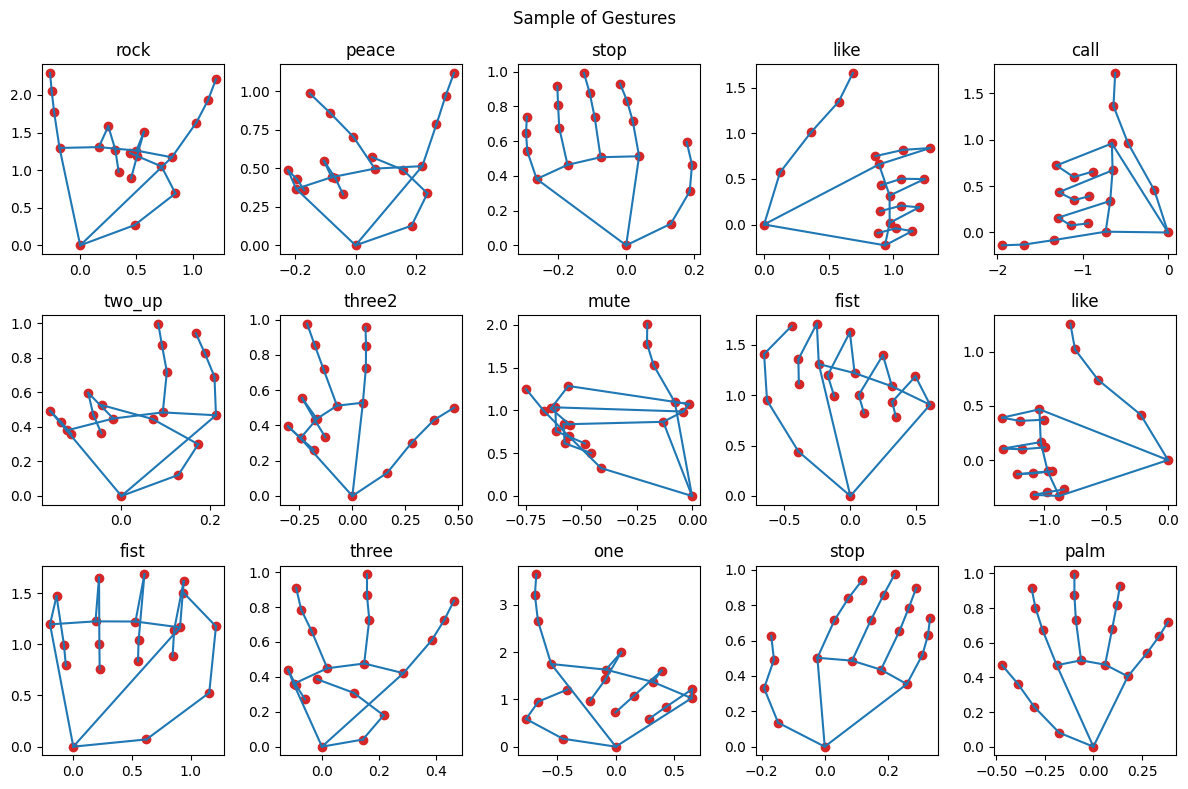

In [26]:
# Visualize a random sample of 15 gestures

sample = preprocessed_data.sample(15, random_state=42)
sample_data = sample.drop(columns=['label'])
sample_labels = sample['label']

plot_gestures(sample_data, sample_labels, rows=3, cols=5, figsize=(12, 8))